# taxi3_QLearning

## taxi3_QLearning For First Homework Submission

In [3]:
import gymnasium as gym
import numpy as np
import time
import random

# === Decoding a state into components ===
# Observation space is encoded as an integer, decoded here:
# ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
# taxi_row: 5 options, taxi_col: 5 options
# passenger_location: 5 (Red, Green, Yellow, Blue, In taxi)
# destination: 4 (Red, Green, Yellow, Blue)
def decode_taxi_state(state):
    taxi_row = (state // 100) % 5
    taxi_col = (state // 20) % 5
    pass_loc = (state // 4) % 5
    dest_idx = state % 4
    return taxi_row, taxi_col, pass_loc, dest_idx

# === Custom map drawing ===
# Shows where the taxi is, and includes layout with labeled destinations. 
def draw_custom_map(taxi_row, taxi_col, pass_loc, dest_idx, carrying):
    map_lines = [
        list("+---------+"),
        list("|R: | : :G|"),  # R and G mark Red and Green destination
        list("| : | : : |"),
        list("| : : : : |"),
        list("| | : | : |"),
        list("|Y| : |B: |"), # Y and B mark Yellow and Blue destination
        list("+---------+")
    ]
    for i in range(len(map_lines)):
        while len(map_lines[i]) < 12:
            map_lines[i].append(' ')

    row_map = [1, 2, 3, 4, 5]
    col_map = [1, 3, 6, 9, 11]

    if 0 <= taxi_row < 5 and 0 <= taxi_col < 5:
        vis_row = row_map[taxi_row]
        vis_col = col_map[taxi_col]
        taxi_symbol = "T"  # taxi symbol shown on the map
        map_lines[vis_row][vis_col] = taxi_symbol

    return '\n'.join(''.join(line) for line in map_lines)

# === Text representation of actions ===
action_names = {
    0: "South ↓",
    1: "North ↑",
    2: "East →",
    3: "West ←",
    4: "Pickup :)",
    5: "Dropoff ⬇"
}

# === Q-Learning Algorithm ===
# Model-free learning: learns from trial and error using the reward feedback
def q_learning(env, alpha=0.1, gamma=0.99, epsilon=0.1, episodes=10000):
    nS = env.observation_space.n     # number of states (500)
    nA = env.action_space.n          # number of actions (6)
    Q = np.zeros((nS, nA))           # initialize Q-table

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        truncated = False

        while not done and not truncated:
            # ε-greedy policy: with probability ε choose random action, else best known
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            # Interact with the environment using chosen action
            next_state, reward, done, truncated, _ = env.step(action)

            # Update Q-value towards target reward + estimated future reward
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]
            )

            state = next_state  # move to next state

    # === Derive optimal policy from Q-table ===
    # For each state, select the action with the highest Q-value
    policy = np.argmax(Q, axis=1)

    return policy, Q

# === Create the environment ===
# Environment simulates the grid world of Taxi-v3 with pickup/dropoff task
env = gym.make("Taxi-v3", render_mode=None)

# === Run Q-learning and get optimal policy and Q-table ===
policy, Q = q_learning(env)

# === Test the learned policy with printed custom map ===
observation, _ = env.reset()
done = False
truncated = False
total_reward = 0
step = 0
locations = ["Red", "Green", "Yellow", "Blue", "In Taxi"]

print("\n Starting Taxi-v3 Simulation using Q-Learning... \n")

while not done and not truncated:
    action = policy[observation]
    taxi_row, taxi_col, pass_idx, dest_idx = decode_taxi_state(observation)
    carrying = pass_idx == 4  # passenger in taxi if 4

    # Display map and step info
    print(draw_custom_map(taxi_row, taxi_col, pass_idx, dest_idx, carrying))
    print(f"Step: {step}")
    print(f"State ID: {observation} → (row={taxi_row}, col={taxi_col}, pass_loc={pass_idx}, dest={dest_idx})")
    print(f"Passenger: {locations[pass_idx]}")
    print(f"Destination: {locations[dest_idx]}")
    print(f"Action: {action_names[action]} ({action})")

    observation, reward, done, truncated, _ = env.step(action)
    total_reward += reward
    print(f"Reward: {reward}")
    print(f"{'-'*30}")
    time.sleep(0.7)
    step += 1

print(f"\n Episode finished in {step} steps with total reward: {total_reward}")
env.close()

# === Print first 10 Q-table entries to console ===
print("\n Sample Q-table (first 10 states)\n")
for state in range(10):
    best_action = np.argmax(Q[state])
    print(f"State {state}: Q-values {Q[state]} → Best Action: {action_names[best_action]}")

# === Save full Q-table to file ===
with open("q_table_output.txt", "w", encoding="utf-8") as f:
    f.write("=== Full Q-table Summary (All 500 States) ===\n\n")
    for state in range(Q.shape[0]):
        best_action = np.argmax(Q[state])
        line = f"State {state}: Q-values {Q[state]} → Best Action: {action_names[best_action]}\n"
        f.write(line)

print("\n Full Q-table has been saved to 'q_table_output.txt'")



 Starting Taxi-v3 Simulation using Q-Learning... 

+---------+ 
|T: | : :G| 
| : | : : | 
| : : : : | 
| | : | : | 
|Y| : |B: | 
+---------+ 
Step: 0
State ID: 3 → (row=0, col=0, pass_loc=0, dest=3)
Passenger: Red
Destination: Blue
Action: Pickup :) (4)
Reward: -1
------------------------------
+---------+ 
|T: | : :G| 
| : | : : | 
| : : : : | 
| | : | : | 
|Y| : |B: | 
+---------+ 
Step: 1
State ID: 19 → (row=0, col=0, pass_loc=4, dest=3)
Passenger: In Taxi
Destination: Blue
Action: South ↓ (0)
Reward: -1
------------------------------
+---------+ 
|R: | : :G| 
|T: | : : | 
| : : : : | 
| | : | : | 
|Y| : |B: | 
+---------+ 
Step: 2
State ID: 119 → (row=1, col=0, pass_loc=4, dest=3)
Passenger: In Taxi
Destination: Blue
Action: South ↓ (0)
Reward: -1
------------------------------
+---------+ 
|R: | : :G| 
| : | : : | 
|T: : : : | 
| | : | : | 
|Y| : |B: | 
+---------+ 
Step: 3
State ID: 219 → (row=2, col=0, pass_loc=4, dest=3)
Passenger: In Taxi
Destination: Blue
Action: East → (2)


## taxi3_QLearning For The Final With Metrics

Starting Q-Learning training for 50000 episodes...
Params: alpha=0.1, gamma=0.99, eps_initial=1.0, eps_min=0.01, eps_decay=0.9999


Training Q-Learning:   5%|▌         | 2556/50000 [00:20<02:03, 385.40it/s]

Ep 2500/50000, Avg Rew (last 100): -233.94, Eps: 0.779, Success (last 100): 0.99


Training Q-Learning:  10%|█         | 5039/50000 [00:29<02:11, 342.88it/s]

Ep 5000/50000, Avg Rew (last 100): -87.49, Eps: 0.607, Success (last 100): 1.00


Training Q-Learning:  16%|█▌        | 7806/50000 [00:34<00:39, 1064.07it/s]

Ep 7500/50000, Avg Rew (last 100): -46.79, Eps: 0.472, Success (last 100): 1.00


Training Q-Learning:  21%|██        | 10308/50000 [00:36<00:26, 1482.34it/s]

Ep 10000/50000, Avg Rew (last 100): -25.17, Eps: 0.368, Success (last 100): 1.00


Training Q-Learning:  25%|██▌       | 12638/50000 [00:38<00:32, 1161.42it/s]

Ep 12500/50000, Avg Rew (last 100): -13.14, Eps: 0.286, Success (last 100): 1.00


Training Q-Learning:  30%|███       | 15159/50000 [00:41<00:43, 793.19it/s] 

Ep 15000/50000, Avg Rew (last 100): -6.59, Eps: 0.223, Success (last 100): 1.00


Training Q-Learning:  35%|███▌      | 17579/50000 [00:44<00:37, 869.34it/s]

Ep 17500/50000, Avg Rew (last 100): -1.24, Eps: 0.174, Success (last 100): 1.00


Training Q-Learning:  40%|████      | 20142/50000 [00:47<00:39, 762.36it/s]

Ep 20000/50000, Avg Rew (last 100): 0.40, Eps: 0.135, Success (last 100): 1.00


Training Q-Learning:  45%|████▌     | 22693/50000 [00:50<00:29, 917.96it/s]

Ep 22500/50000, Avg Rew (last 100): 3.51, Eps: 0.105, Success (last 100): 1.00


Training Q-Learning:  51%|█████     | 25402/50000 [00:52<00:11, 2199.00it/s]

Ep 25000/50000, Avg Rew (last 100): 3.31, Eps: 0.082, Success (last 100): 1.00


Training Q-Learning:  56%|█████▌    | 27941/50000 [00:53<00:10, 2044.45it/s]

Ep 27500/50000, Avg Rew (last 100): 3.17, Eps: 0.064, Success (last 100): 1.00


Training Q-Learning:  61%|██████    | 30409/50000 [00:54<00:09, 2101.01it/s]

Ep 30000/50000, Avg Rew (last 100): 5.79, Eps: 0.050, Success (last 100): 1.00


Training Q-Learning:  66%|██████▌   | 32861/50000 [00:55<00:07, 2301.46it/s]

Ep 32500/50000, Avg Rew (last 100): 6.46, Eps: 0.039, Success (last 100): 1.00


Training Q-Learning:  71%|███████   | 35258/50000 [00:57<00:12, 1154.49it/s]

Ep 35000/50000, Avg Rew (last 100): 7.08, Eps: 0.030, Success (last 100): 1.00


Training Q-Learning:  75%|███████▌  | 37707/50000 [00:59<00:12, 1017.45it/s]

Ep 37500/50000, Avg Rew (last 100): 6.43, Eps: 0.024, Success (last 100): 1.00


Training Q-Learning:  80%|████████  | 40117/50000 [01:01<00:09, 1070.01it/s]

Ep 40000/50000, Avg Rew (last 100): 6.86, Eps: 0.018, Success (last 100): 1.00


Training Q-Learning:  85%|████████▌ | 42726/50000 [01:04<00:06, 1097.91it/s]

Ep 42500/50000, Avg Rew (last 100): 7.05, Eps: 0.014, Success (last 100): 1.00


Training Q-Learning:  90%|█████████ | 45168/50000 [01:06<00:04, 1076.06it/s]

Ep 45000/50000, Avg Rew (last 100): 7.51, Eps: 0.011, Success (last 100): 1.00


Training Q-Learning:  96%|█████████▌| 47992/50000 [01:09<00:01, 1821.24it/s]

Ep 47500/50000, Avg Rew (last 100): 7.15, Eps: 0.010, Success (last 100): 1.00


Training Q-Learning: 100%|██████████| 50000/50000 [01:09<00:00, 715.06it/s] 


Ep 50000/50000, Avg Rew (last 100): 7.74, Eps: 0.010, Success (last 100): 1.00
Q-Learning Training Time: 69.93 seconds


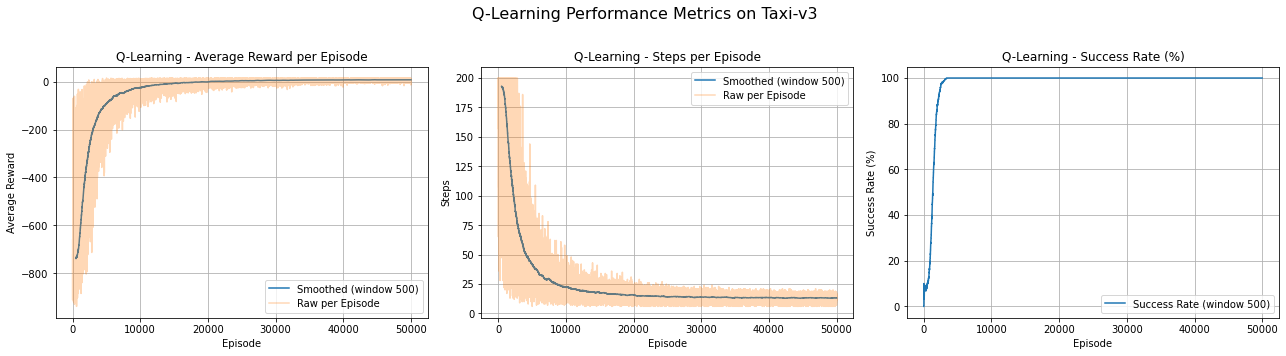


--- Evaluating Final Q-Learning Policy for 1000 episodes ---


Evaluating Q-Learning Policy: 100%|██████████| 1000/1000 [00:00<00:00, 4132.28it/s]


--- Q-Learning Policy Evaluation Results ---
Average Reward: 7.97 +/- 2.63
Average Steps: 13.03 +/- 2.63
Success Rate: 100.00%

--- Q-Learning Metrics Summary ---
Algorithm: Q-Learning (Tabular)
Training Time (s): 69.93
Hyperparameters: alpha=0.1, gamma=0.99, eps_decay=0.9999, episodes=50000
Avg Reward per Ep (Learning Curve End): 7.74
Steps per Ep (Learning Curve End): 12.90
Success Rate (Learning Curve End %): 100.00
Convergence Speed (approx. episodes to >80% success): Observe from plot
Final Policy - Avg Reward: 7.97 ± 2.63
Final Policy - Avg Steps: 13.03 ± 2.63
Final Policy - Success Rate (%): 100.00

--- Simulating one episode with the Q-Learning policy ---
+---------+ 
|R: | : :G| 
| : | : : | 
| : : : : | 
| | : T : | 
|Y| : |B: | 
+---------+ 
Step: 0, State ID: 341 → (row=3, col=2, pass_loc=R (Red), dest=G (Green))
Action: North ↑ (1), Q-vals for this state: [ 1.73348219  4.24949753  3.1266996   4.20730322 -5.81875125 -5.86048825]
Reward: -1, Total Reward: -1
----------------

In [2]:
import gymnasium as gym
import numpy as np
import time
import random
import matplotlib.pyplot as plt 
from tqdm import tqdm 

# === Decoding a state into components ===
def decode_taxi_state(state):
    taxi_row = (state // 100) % 5
    taxi_col = (state // 20) % 5
    pass_loc = (state // 4) % 5
    dest_idx = state % 4
    return taxi_row, taxi_col, pass_loc, dest_idx

# === Custom map drawing ===
def draw_custom_map(taxi_row, taxi_col, pass_loc, dest_idx, carrying):
    map_lines = [
        list("+---------+"), list("|R: | : :G|"), list("| : | : : |"),
        list("| : : : : |"), list("| | : | : |"), list("|Y| : |B: |"),
        list("+---------+")
    ]
    for i in range(len(map_lines)):
        while len(map_lines[i]) < 12: map_lines[i].append(' ')
    row_map = [1, 2, 3, 4, 5]
    col_map = [1, 3, 6, 9, 11]
    if 0 <= taxi_row < 5 and 0 <= taxi_col < 5:
        vis_row = row_map[taxi_row]
        vis_col = col_map[taxi_col]
        map_lines[vis_row][vis_col] = "T"
    return '\n'.join(''.join(line) for line in map_lines)

# === Text representation of actions ===
action_names = {
    0: "South ↓", 1: "North ↑", 2: "East →",
    3: "West ←", 4: "Pickup :)", 5: "Dropoff ⬇"
}
locations = ["R (Red)", "G (Green)", "Y (Yellow)", "B (Blue)", "In Taxi"]

# === Q-Learning Algorithm with Metrics Collection ===
def q_learning_with_metrics(env, alpha=0.1, gamma=0.99, 
                            epsilon_initial=1.0, epsilon_min=0.01, 
                            epsilon_decay_rate=0.9995, # Multiplicative decay
                            episodes=20000): # Tabular Q-learning often needs many episodes
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA))

    # For metrics
    rewards_per_episode = []
    steps_per_episode = []
    successes_per_episode = [] # 1 if success, 0 otherwise
    
    current_epsilon = epsilon_initial

    print(f"Starting Q-Learning training for {episodes} episodes...")
    print(f"Params: alpha={alpha}, gamma={gamma}, eps_initial={epsilon_initial}, eps_min={epsilon_min}, eps_decay={epsilon_decay_rate}")

    for ep in tqdm(range(episodes), desc="Training Q-Learning"):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        episode_steps = 0
        max_steps_per_episode = 200 # Taxi-v3 default

        while not done and not truncated and episode_steps < max_steps_per_episode:
            if random.uniform(0, 1) < current_epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, truncated, _ = env.step(action)

            # Q-learning update rule
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]
            )

            state = next_state
            episode_reward += reward
            episode_steps += 1
        
        rewards_per_episode.append(episode_reward)
        steps_per_episode.append(episode_steps)
        successes_per_episode.append(1 if done and reward == 20 else 0)

        # Decay epsilon (multiplicative decay)
        current_epsilon = max(epsilon_min, current_epsilon * epsilon_decay_rate)
        
        if (ep + 1) % (episodes // 20 if episodes >= 20 else 1) == 0:
             print(f"Ep {ep+1}/{episodes}, Avg Rew (last 100): {np.mean(rewards_per_episode[-100:]):.2f}, Eps: {current_epsilon:.3f}, Success (last 100): {np.mean(successes_per_episode[-100:]):.2f}")


    policy = np.argmax(Q, axis=1)
    learning_curves = {
        "rewards": rewards_per_episode,
        "steps": steps_per_episode,
        "successes": successes_per_episode
    }
    return policy, Q, learning_curves

# === Evaluate Final Policy Performance (same as for Policy Iteration) ===
def evaluate_policy(env, policy, num_episodes=1000, algorithm_name="Policy"):
    total_rewards = []
    total_steps = []
    successful_dropoffs = 0

    print(f"\n--- Evaluating Final {algorithm_name} for {num_episodes} episodes ---")
    for i in tqdm(range(num_episodes), desc=f"Evaluating {algorithm_name}"):
        observation, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        episode_steps = 0
        for _ in range(200): 
            action = policy[observation]
            observation, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            episode_steps += 1
            if done or truncated:
                break
        total_rewards.append(episode_reward)
        total_steps.append(episode_steps)
        if done and reward == 20:
            successful_dropoffs += 1
            
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    avg_steps = np.mean(total_steps)
    std_steps = np.std(total_steps)
    success_rate = (successful_dropoffs / num_episodes) * 100

    print(f"--- {algorithm_name} Evaluation Results ---")
    print(f"Average Reward: {avg_reward:.2f} +/- {std_reward:.2f}")
    print(f"Average Steps: {avg_steps:.2f} +/- {std_steps:.2f}")
    print(f"Success Rate: {success_rate:.2f}%")
    
    return avg_reward, avg_steps, success_rate, std_reward, std_steps

# === Plot Learning Curves ===
def plot_learning_curves(learning_curves_data, algorithm_name="Algorithm"):
    num_episodes = len(learning_curves_data["rewards"])
    episodes_axis = np.arange(1, num_episodes + 1)
    
    # Smoothing window
    window = max(1, num_episodes // 100 if num_episodes > 100 else 50)

    plt.figure(figsize=(18, 5))
    plt.suptitle(f"Q-Learning Performance Metrics on Taxi-v3", fontsize=16)

    # Plot Average Reward
    plt.subplot(1, 3, 1)
    if num_episodes >= window:
        smoothed_rewards = np.convolve(learning_curves_data["rewards"], np.ones(window)/window, mode='valid')
        plt.plot(episodes_axis[window-1:], smoothed_rewards, label=f'Smoothed (window {window})')
    plt.plot(episodes_axis, learning_curves_data["rewards"], alpha=0.3, label='Raw per Episode')
    plt.title(f'{algorithm_name} - Average Reward per Episode')
    plt.xlabel('Episode'); plt.ylabel('Average Reward'); plt.legend(); plt.grid(True)

    # Plot Average Steps
    plt.subplot(1, 3, 2)
    if num_episodes >= window:
        smoothed_steps = np.convolve(learning_curves_data["steps"], np.ones(window)/window, mode='valid')
        plt.plot(episodes_axis[window-1:], smoothed_steps, label=f'Smoothed (window {window})')
    plt.plot(episodes_axis, learning_curves_data["steps"], alpha=0.3, label='Raw per Episode')
    plt.title(f'{algorithm_name} - Steps per Episode')
    plt.xlabel('Episode'); plt.ylabel('Steps'); plt.legend(); plt.grid(True)

    # Plot Success Rate
    plt.subplot(1, 3, 3)
    success_rate_curve = []
    for i in range(num_episodes):
        start_idx = max(0, i - window + 1)
        current_window_successes = np.mean(learning_curves_data["successes"][start_idx : i+1])
        success_rate_curve.append(current_window_successes * 100)
    plt.plot(episodes_axis, success_rate_curve, label=f'Success Rate (window {window})')
    plt.title(f'{algorithm_name} - Success Rate (%)')
    plt.xlabel('Episode'); plt.ylabel('Success Rate (%)'); plt.ylim(-5, 105); plt.legend(); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()

# === Main Execution ===

if __name__ == "__main__":
    env_q = gym.make("Taxi-v3")

    # --- Q-Learning Parameters ---
    q_alpha = 0.1               # Learning rate
    q_gamma = 0.99              # Discount factor
    q_epsilon_initial = 1.0     # Initial exploration rate
    q_epsilon_min = 0.01        # Minimum exploration rate
    q_epsilon_decay = 0.9999    # Multiplicative decay rate for epsilon (slower decay for more episodes)
    q_episodes = 50000          # Number of training episodes for Q-learning (try 20k to 100k)

    # --- 1. Run Q-Learning and Collect Training Metrics ---
    q_learning_start_time = time.time()
    q_policy, q_table_learned, q_learning_curves = q_learning_with_metrics( # Renamed to q_table_learned
        env_q, 
        alpha=q_alpha, 
        gamma=q_gamma, 
        epsilon_initial=q_epsilon_initial, 
        epsilon_min=q_epsilon_min,
        epsilon_decay_rate=q_epsilon_decay,
        episodes=q_episodes
    )
    q_training_time = time.time() - q_learning_start_time
    print(f"Q-Learning Training Time: {q_training_time:.2f} seconds")

    # --- 2. Plot Learning Curves ---
    if q_learning_curves["rewards"]: 
        plot_learning_curves(q_learning_curves, algorithm_name="Q-Learning")
    else:
        print("No learning curve data to plot for Q-Learning.")


    # --- 3. Evaluate the Final Policy from Q-Learning ---
    q_avg_reward, q_avg_steps, q_success_rate, q_std_reward, q_std_steps = evaluate_policy(
        env_q, q_policy, num_episodes=1000, algorithm_name="Q-Learning Policy"
    )

    # --- 4. Store Metrics for Report ---
    q_learning_metrics = {
        "Algorithm": "Q-Learning (Tabular)",
        "Training Time (s)": f"{q_training_time:.2f}",
        "Hyperparameters": f"alpha={q_alpha}, gamma={q_gamma}, eps_decay={q_epsilon_decay}, episodes={q_episodes}",
        "Avg Reward per Ep (Learning Curve End)": f"{np.mean(q_learning_curves['rewards'][-100:]):.2f}" if q_episodes >=100 and q_learning_curves['rewards'] else "N/A",
        "Steps per Ep (Learning Curve End)": f"{np.mean(q_learning_curves['steps'][-100:]):.2f}" if q_episodes >=100 and q_learning_curves['steps'] else "N/A",
        "Success Rate (Learning Curve End %)": f"{np.mean(q_learning_curves['successes'][-100:])*100:.2f}" if q_episodes >=100 and q_learning_curves['successes'] else "N/A",
        "Convergence Speed (approx. episodes to >80% success)": "Observe from plot", 
        "Final Policy - Avg Reward": f"{q_avg_reward:.2f} ± {q_std_reward:.2f}",
        "Final Policy - Avg Steps": f"{q_avg_steps:.2f} ± {q_std_steps:.2f}",
        "Final Policy - Success Rate (%)": f"{q_success_rate:.2f}",
    }
    
    print("\n--- Q-Learning Metrics Summary ---")
    for key, value in q_learning_metrics.items():
        print(f"{key}: {value}")

    # --- 5. Simulate one episode with the learned policy ---
    print("\n--- Simulating one episode with the Q-Learning policy ---")
    observation, _ = env_q.reset(seed=123) 
    done = False
    truncated = False
    total_reward_sim = 0
    step_sim = 0

    for _ in range(50): 
        action = q_policy[observation] 
        taxi_row, taxi_col, pass_idx, dest_idx = decode_taxi_state(observation)
        carrying = pass_idx == 4
        
        print(draw_custom_map(taxi_row, taxi_col, pass_idx, dest_idx, carrying))
        print(f"Step: {step_sim}, State ID: {observation} → (row={taxi_row}, col={taxi_col}, pass_loc={locations[pass_idx]}, dest={locations[dest_idx]})")
        # Use q_table_learned here
        print(f"Action: {action_names[action]} ({action}), Q-vals for this state: {q_table_learned[observation]}") 
        
        observation, reward, done, truncated, _ = env_q.step(action)
        total_reward_sim += reward
        print(f"Reward: {reward}, Total Reward: {total_reward_sim}")
        print(f"{'-'*30}")
        time.sleep(0.3)
        step_sim += 1
        if done or truncated: break
    
    print(f"\nQ-Learning Simulation finished in {step_sim} steps with total reward: {total_reward_sim}")
    if done and reward == 20: print("Successful Dropoff in Q-Learning simulation!")

    env_q.close()

    # === Save full Q-table to file ===
    print("\nAttempting to save Q-table...")
    if 'q_table_learned' in locals() and q_table_learned is not None: 
        with open("q_table_final_output.txt", "w", encoding="utf-8") as f:
            f.write("=== Full Q-table Summary (All 500 States) ===\n\n")
            for state_idx in range(q_table_learned.shape[0]): #
                best_action_idx = np.argmax(q_table_learned[state_idx]) 
                action_name_str = action_names.get(best_action_idx, f"Unknown action index: {best_action_idx}")
                line = f"State {state_idx}: Q-values {q_table_learned[state_idx]} → Best Action: {action_name_str}\n" 
                f.write(line)
        print("Full Q-table has been saved to 'q_table_final_output.txt'")
    else:
        print("Q-table ('q_table_learned') not available for saving.")